In [21]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
signal_trees = TreeIter(list(map(Tree,fc.eightb.accstudies_no_pu.signal_list)))
signal_trees_pu = TreeIter(list(map(Tree,fc.eightb.accstudies.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

In [24]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [25]:
dout = "gen_studies/recojets/"

tree = signal_trees[-2]
tree_pu = signal_trees_pu[-2]

In [26]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [27]:
varinfo.clear()

In [28]:
def make_recojet_variables(tree):
    recojets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_recojet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt','ptRegressed', 'eta', 'phi', 'm')
    })
    
    genjets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_genjet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    
    recojet_matched = 1*(recojets.pt>0)
    
    gen_var = dict(ptRegressed='pt')
    
    return dict(
        **{
            f'{quark}_recojet_genjet_matched': recojet_matched[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_recojet_{var}_res': (recojets[var]/genjets[gen_var.get(var,var)])[:,i]
            for i,quark in enumerate(quarklist)
            for var in ('pt', 'ptRegressed', 'eta', 'phi',)
        },
        **{
            f'{quark}_recojet_pt_regression': (recojets.ptRegressed/recojets.pt)[:,i]
            for i,quark in enumerate(quarklist)
        },
    )

In [29]:
signal_trees.extend(kwargs=make_recojet_variables)
signal_trees.extend(kwargs=eightb.make_genjet_variables)
signal_trees.extend(kwargs=lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark'))


[None, None, None, None, None, None, None, None]

In [30]:
signal_trees_pu.extend(kwargs=make_recojet_variables)
signal_trees_pu.extend(kwargs=eightb.make_genjet_variables)
signal_trees_pu.extend(kwargs=lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark'))


[None, None, None, None, None, None, None, None]

In [31]:
tree.gen_quark_recojet_ptRegressed

<Array [[253, -999, 89.8, ... 86.7, -999]] type='100000 * var * float32'>

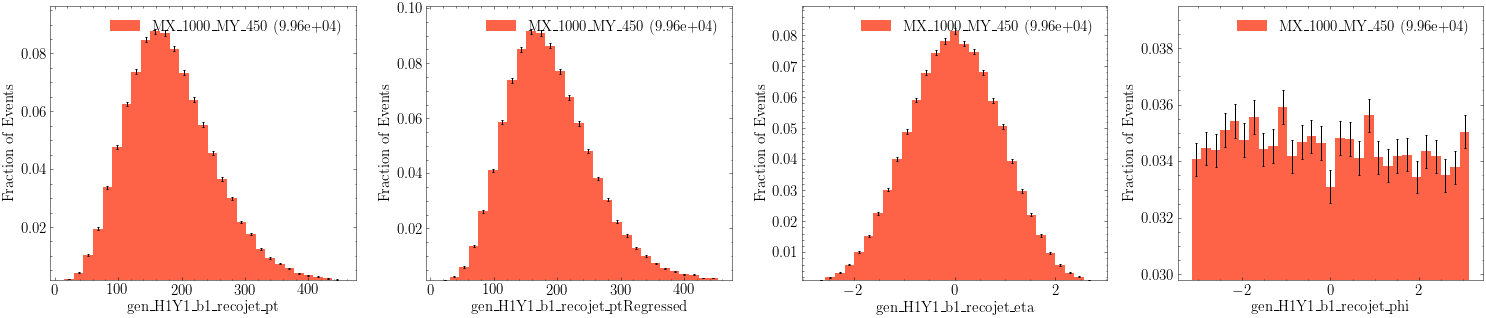

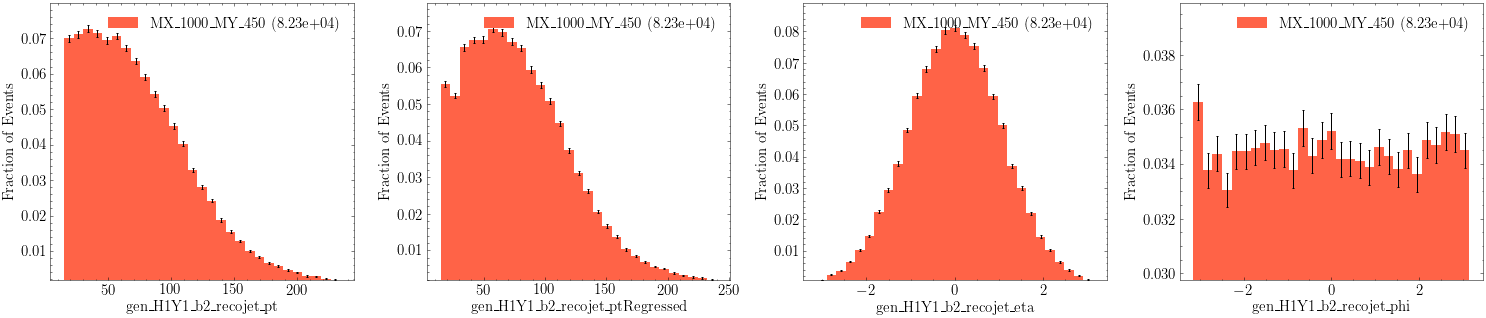

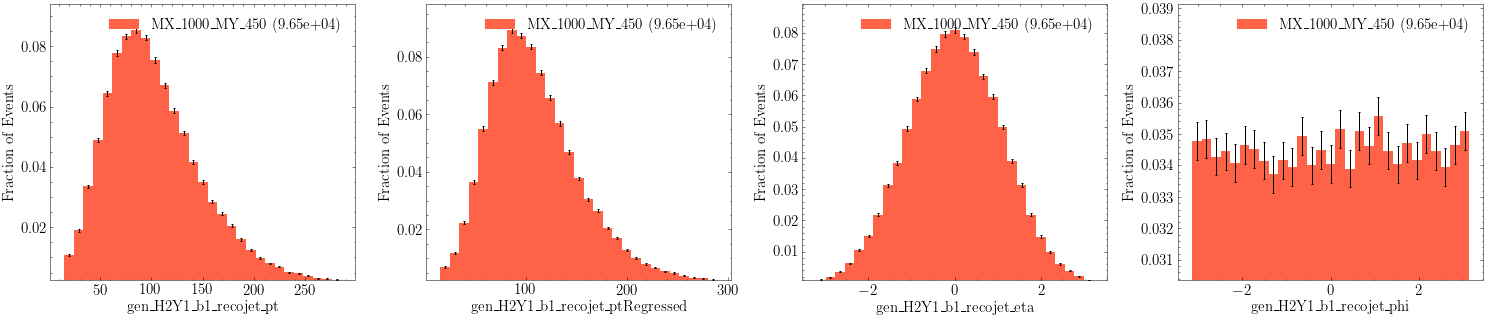

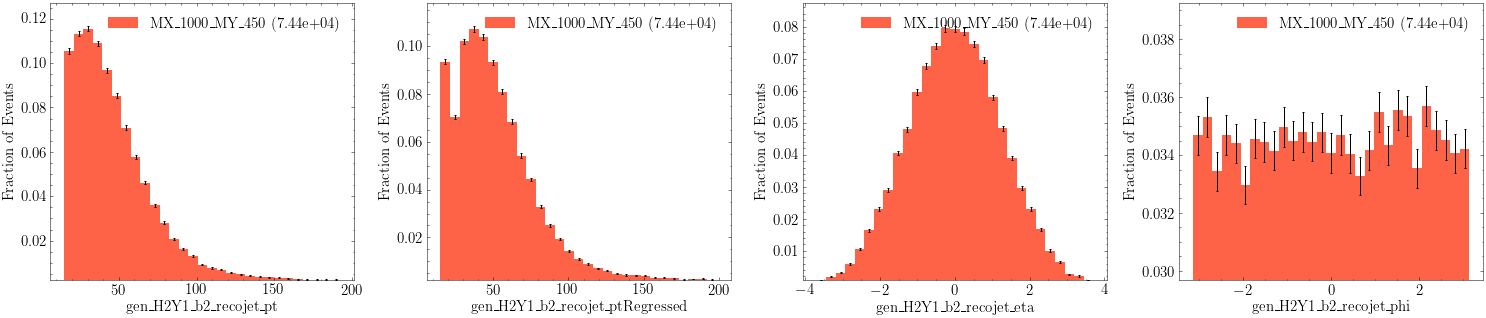

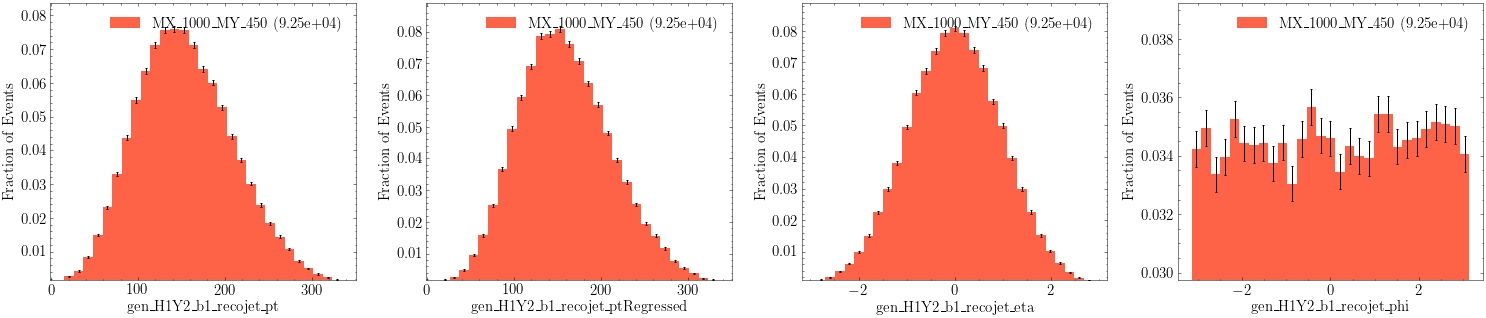

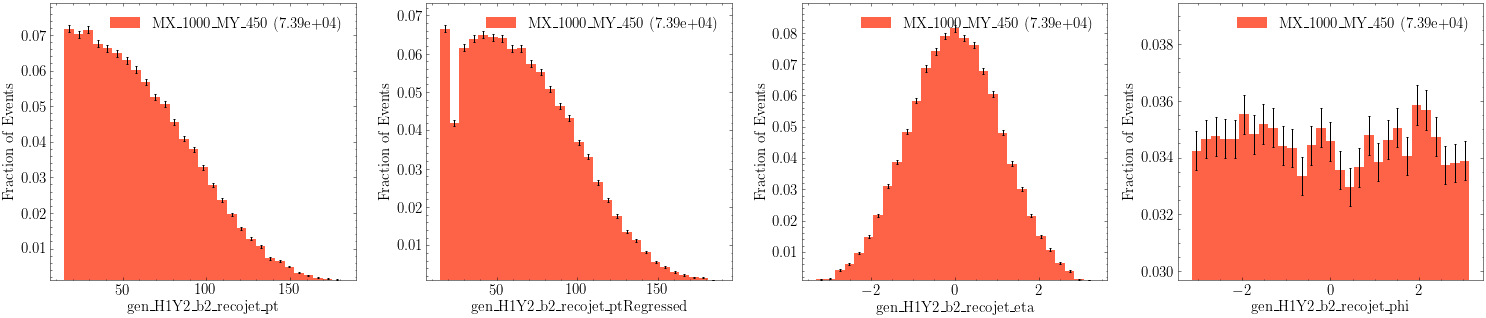

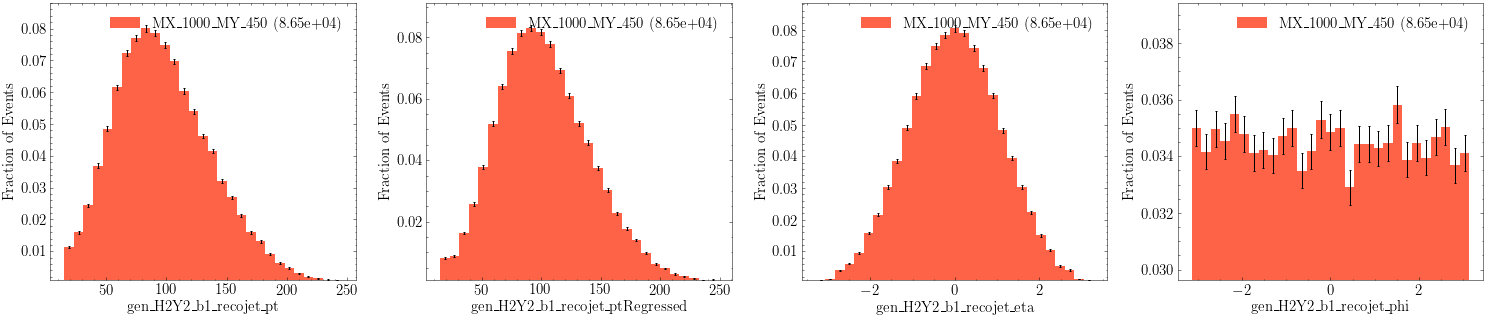

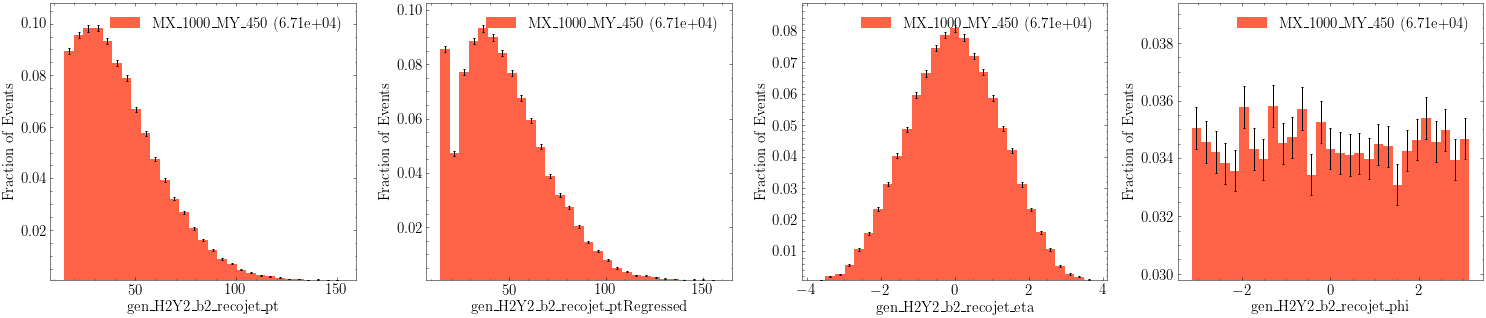

In [32]:
varlist = ['pt','ptRegressed','eta','phi']

for quark in quarklist:
    study.quick(
        [tree],
        masks=[tree[f'{quark}_recojet_pt']>0],
        varlist=[f'{quark}_recojet_{var}' for var in varlist],
        scale=False,
        density=1,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{quark}'
    )

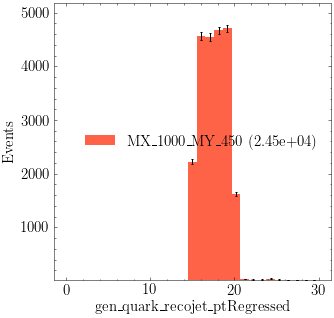

In [33]:
quark = 'gen_quark'
study.quick(
    [tree],
    masks=[(tree[f'{quark}_recojet_pt']>0) & (tree[f'{quark}_recojet_pt_regression'] == 1)],
    varlist=[f'{quark}_recojet_ptRegressed'],
    # s_label_stat=None,
    scale=False,
    binlist=[np.linspace(0,30,30)],
    # ratio=True,
    # saveas=f'{dout}/ptRegressed_impact'
    )


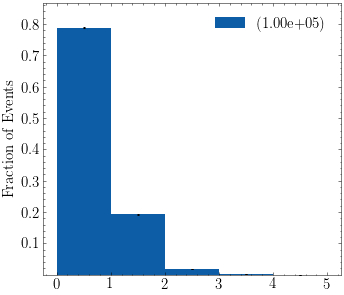

In [34]:
n_lowpt_jets = ak.sum((tree.gen_quark_recojet_ptRegressed > 0) & (tree.gen_quark_recojet_ptRegressed < 20),axis=-1)

hist_multi([n_lowpt_jets],density=1);

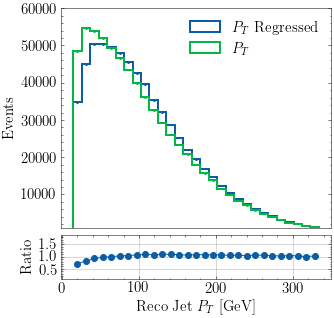

In [35]:
study.overlay(
    [tree],
    masks=[tree['gen_quark_recojet_pt']>0],
    varlist=['gen_quark_recojet_ptRegressed','gen_quark_recojet_pt'],
    xlabels=["Reco Jet $P_{T}$ [GeV]"],
    s_label_stat=None,
    labels=['$P_{T}$ Regressed','$P_{T}$'],
    scale=False,
    ratio=True,
    saveas=f'{dout}/ptRegressed_impact'
    )


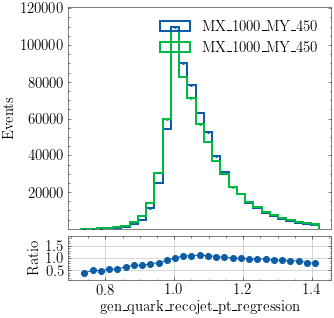

In [36]:
study.quick(
    [tree,tree_pu],
    masks=[t[f'gen_quark_recojet_pt']>0 for t in [tree,tree_pu]],
    varlist=['gen_quark_recojet_pt_regression'],
    # xlabels=["Reco Jet $P_{T}$ [GeV]"],
    s_label_stat=None,
    s_colors=[None],
    # labels=['$P_{T}$ Regressed','$P_{T}$'],
    scale=False,
    ratio=True,
    saveas=f'{dout}/ptRegressed_impact'
    )

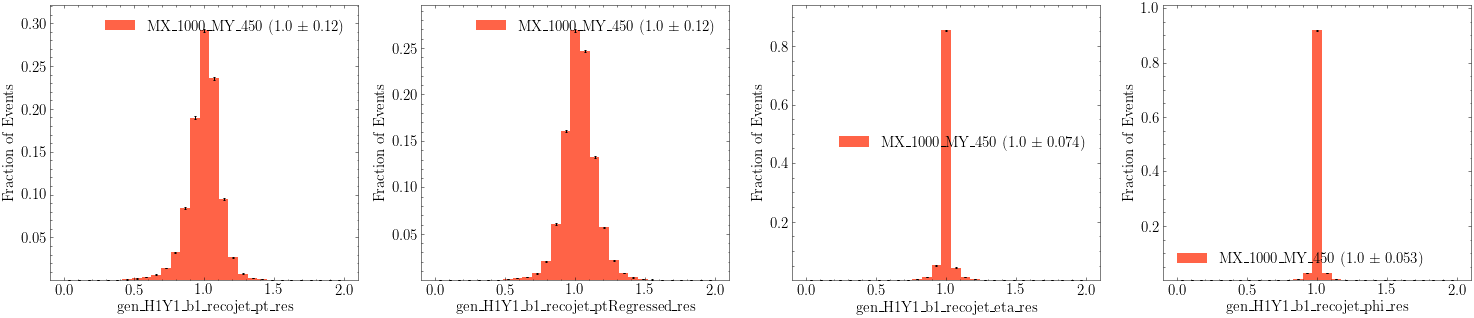

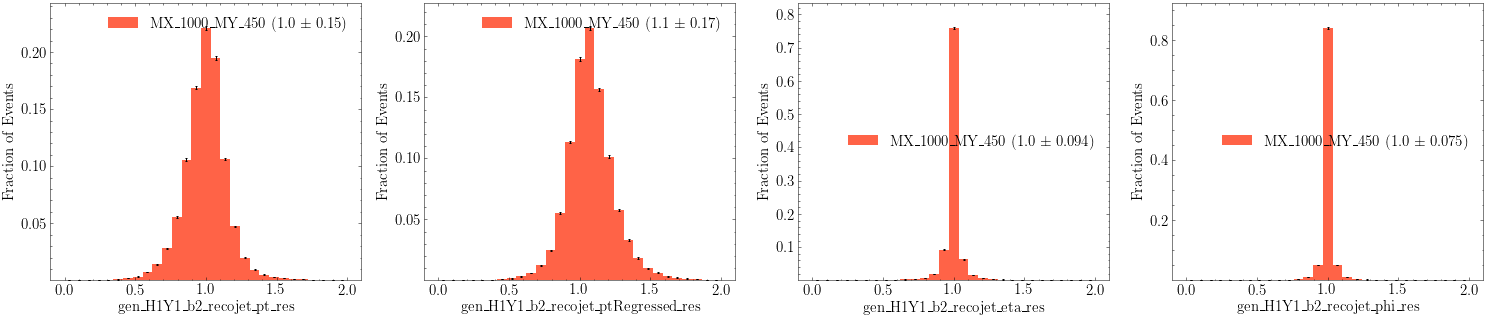

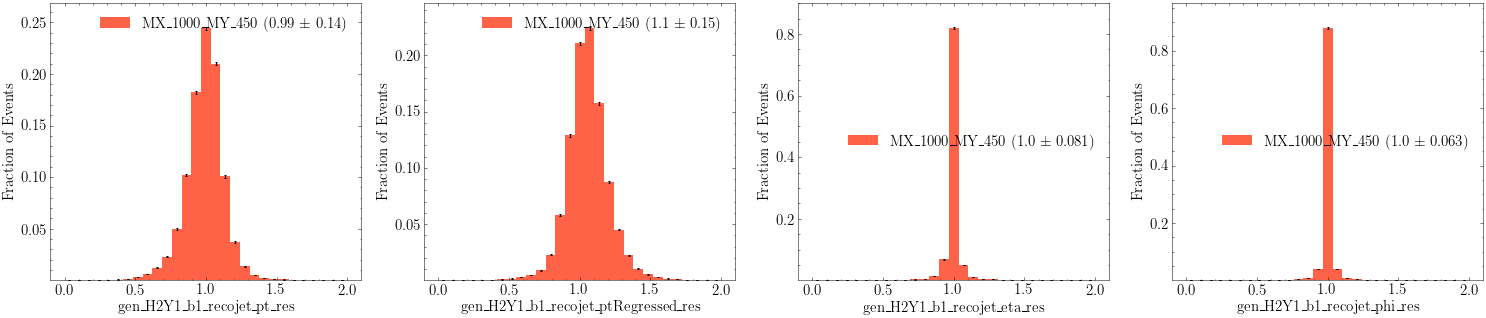

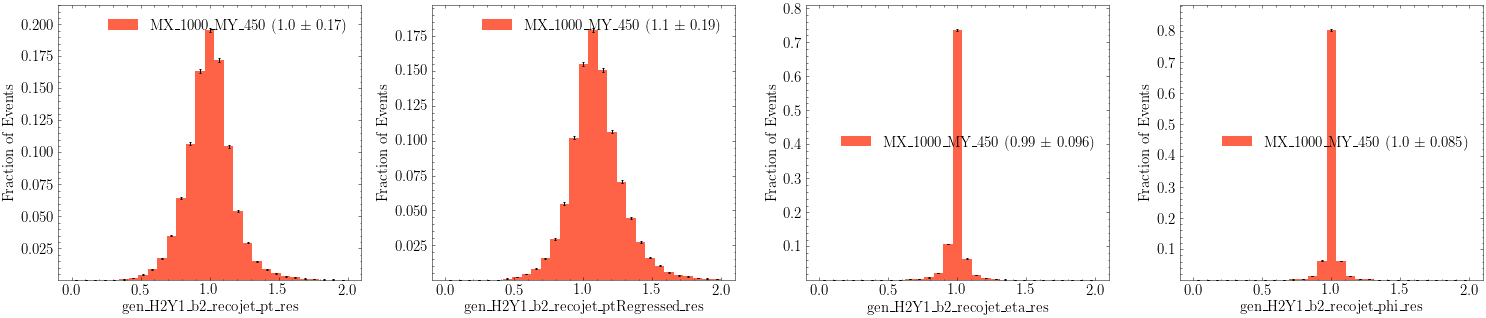

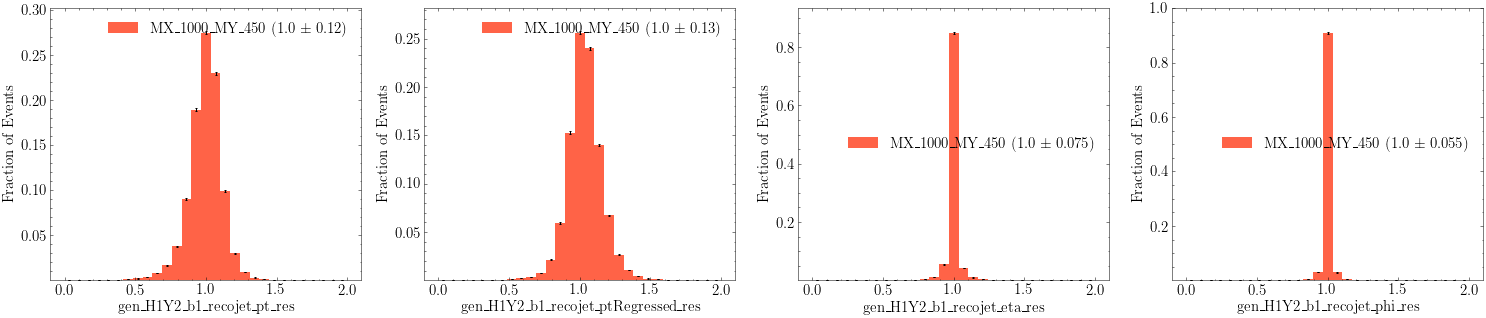

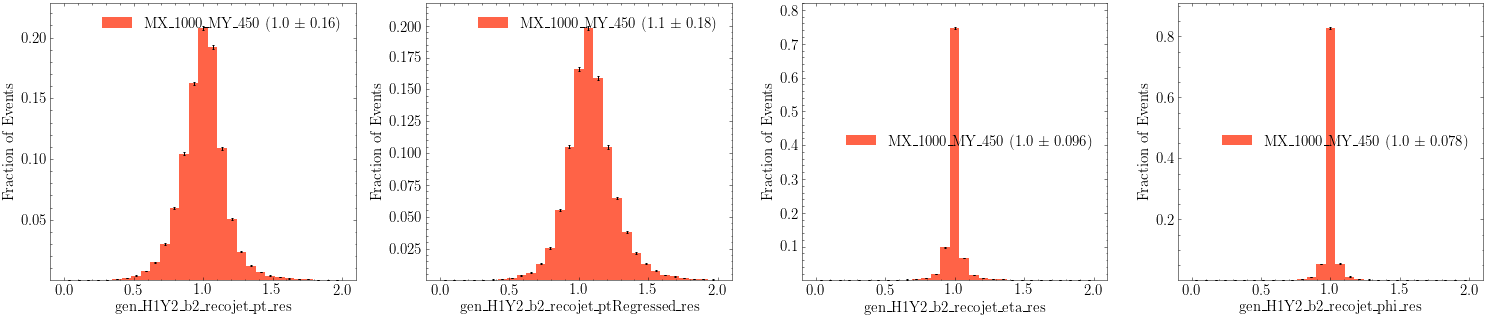

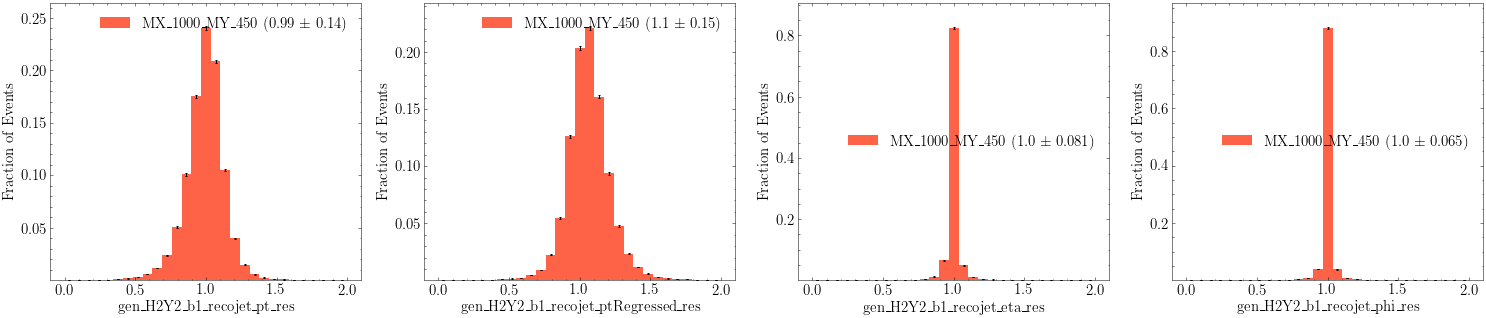

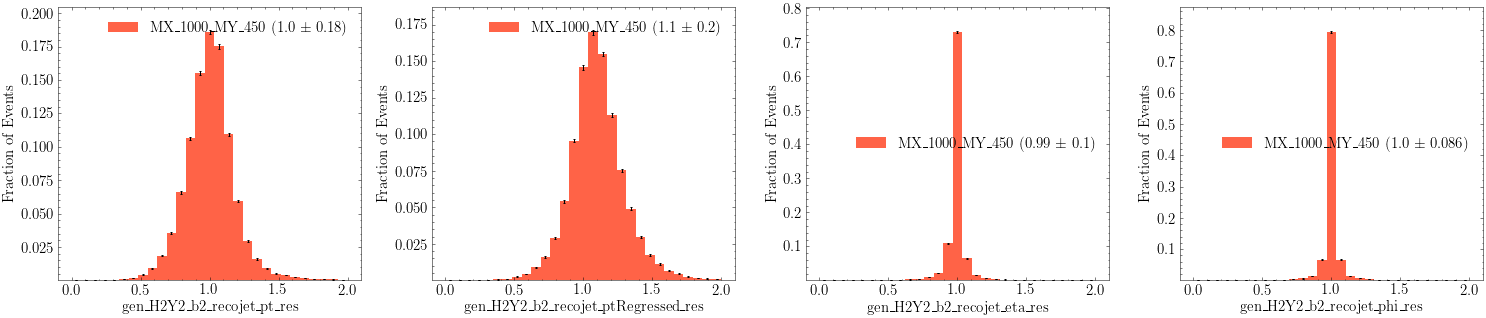

In [37]:
varlist = ['pt','ptRegressed','eta','phi']

for quark in quarklist:
    study.quick(
        [tree],
        masks=[tree[f'{quark}_recojet_pt']>0],
        varlist=[f'{quark}_recojet_{var}_res' for var in varlist],
        scale=False,
        density=1,
        binlist=[np.linspace(0,2,30)]*len(varlist),
        s_label_stat='mean_stdv',
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{quark}_res'
    )

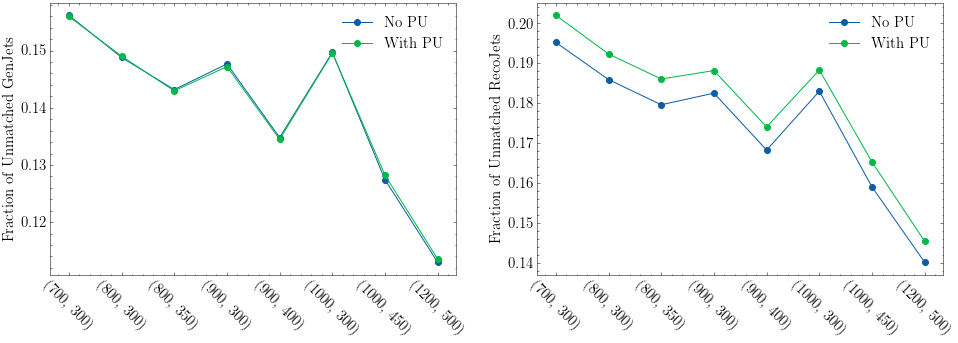

In [38]:
frac_unmatched_genjet = [ ak.sum(t.gen_quark_genjet_quark_matched==0)/ak.count(t.gen_quark_genjet_quark_matched) for t in signal_trees ]
frac_unmatched_genjet_pu = [ ak.sum(t.gen_quark_genjet_quark_matched==0)/ak.count(t.gen_quark_genjet_quark_matched) for t in signal_trees_pu ]

frac_unmatched_recojet = [ ak.sum(t.gen_quark_genjet_recojet_matched==0)/ak.count(t.gen_quark_genjet_recojet_matched) for t in signal_trees ]
frac_unmatched_recojet_pu = [ ak.sum(t.gen_quark_genjet_recojet_matched==0)/ak.count(t.gen_quark_genjet_recojet_matched) for t in signal_trees_pu ]

fig,axs = plt.subplots(ncols=2,figsize=(16,5))

graph_multi(signal_points,[frac_unmatched_genjet,frac_unmatched_genjet_pu],ylabel='Fraction of Unmatched GenJets',labels=["No PU","With PU"],xlabel=signal_points,figax=(fig,axs[0]))
graph_multi(signal_points,[frac_unmatched_recojet,frac_unmatched_recojet_pu],ylabel='Fraction of Unmatched RecoJets',labels=["No PU","With PU"],xlabel=signal_points,figax=(fig,axs[1]))

study.save_fig(fig,'',f'{dout}/pu_matching_impact')


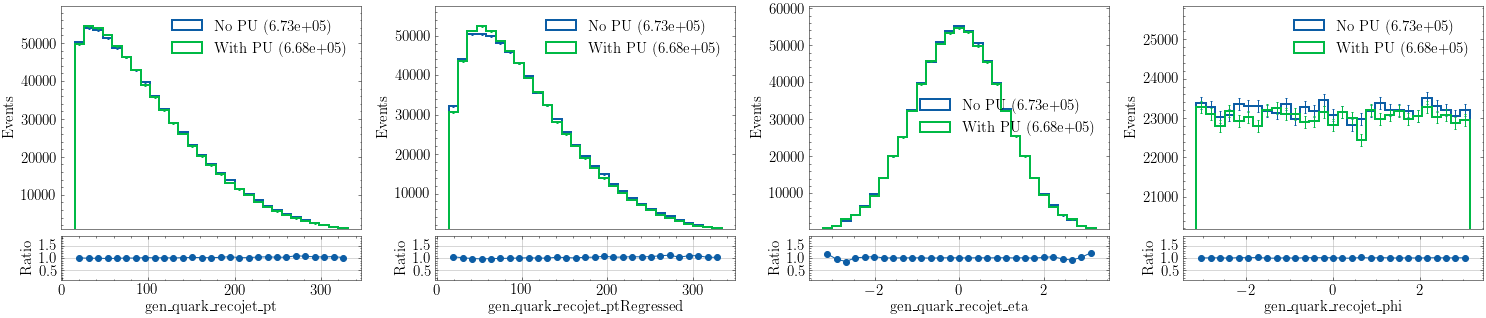

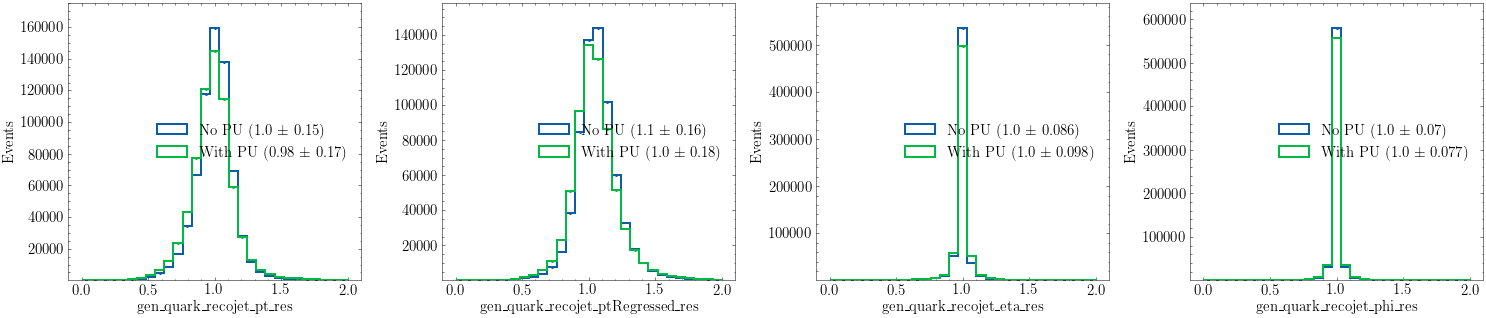

In [39]:
varlist = ['pt','ptRegressed','eta','phi']
treeiter = TreeIter([tree,tree_pu])
study.quick(
    treeiter,
    masks=[t[f'gen_quark_recojet_pt']>0 for t in treeiter],
    varlist=[f'gen_quark_recojet_{var}' for var in varlist],
    scale=False,
    s_colors=[None],
    labels=["No PU","With PU"],
    ratio=True,
    # density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/pu_jet_impact'
)

study.quick(
    treeiter,
    masks=[t[f'gen_quark_recojet_pt']>0 for t in treeiter],
    varlist=[f'gen_quark_recojet_{var}_res' for var in varlist],
    scale=False,
    s_colors=[None],
    labels=["No PU","With PU"],
    s_label_stat='mean_stdv',
    # ratio=True,
    binlist=[np.linspace(0,2,30)]*len(varlist),
    # density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/pu_jet_impact_res'
)

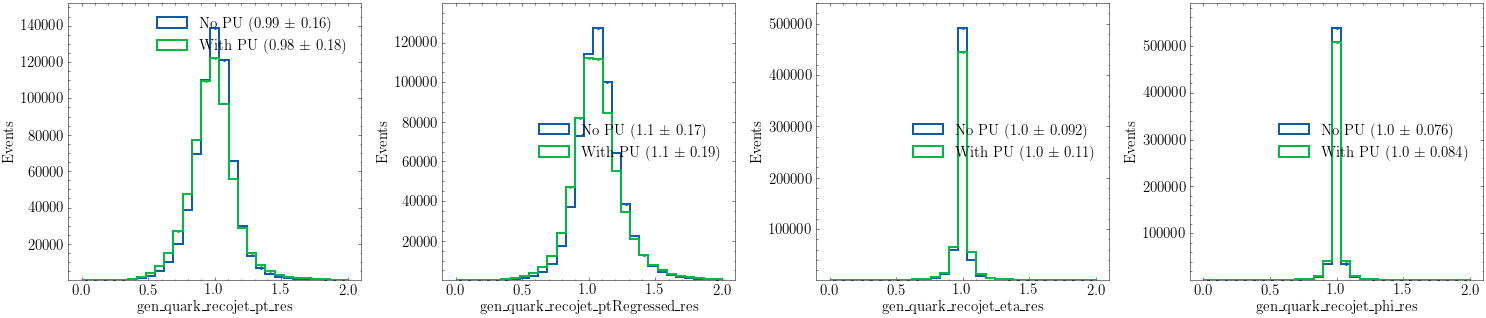

In [40]:
treeiter = TreeIter([signal_trees[0],signal_trees_pu[0]])
study.quick(
    treeiter,
    masks=[t[f'gen_quark_recojet_pt']>0 for t in treeiter],
    varlist=[f'gen_quark_recojet_{var}_res' for var in varlist],
    scale=False,
    s_colors=[None],
    labels=["No PU","With PU"],
    s_label_stat='mean_stdv',
    # ratio=True,
    binlist=[np.linspace(0,2,30)]*len(varlist),
    # density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/pu_jet_impact_res'
)